<a href="https://colab.research.google.com/github/DanielKorenDataScience/RegressionProject/blob/main/Regression%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: https://www.kaggle.com/muhammetvarl/laptop-price

In [5]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
data_url = 'https://raw.githubusercontent.com/DanielKorenDataScience/RegressionProject/master/laptop_price.csv'
resp = requests.get(data_url)
text = resp.text

with open('laptop_price.csv', 'w') as fh:
    fh.write(text)
  
df = pd.read_csv('laptop_price.csv')

In [11]:
df = pd.read_csv('laptop_price.csv', encoding='ISO-8859–1')

In [12]:
df.head(5)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [ ]:
df.info(null_counts=True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


In [ ]:
col = list(df.columns)
for column in col: #.split():
    print(column, ':')
#    df[column] = df[column].str.strip()
    print(df[column].value_counts())
    print()

    """ Product, Screen Resolution, CPU, Weight """

laptop_ID :
1320    1
453     1
435     1
436     1
437     1
       ..
880     1
881     1
882     1
883     1
1       1
Name: laptop_ID, Length: 1303, dtype: int64

Company :
Dell         297
Lenovo       297
HP           274
Asus         158
Acer         103
MSI           54
Toshiba       48
Apple         21
Samsung        9
Mediacom       7
Razer          7
Microsoft      6
Xiaomi         4
Vero           4
Google         3
Chuwi          3
Fujitsu        3
LG             3
Huawei         2
Name: Company, dtype: int64

Product :
XPS 13                 30
Inspiron 3567          29
250 G6                 21
Vostro 3568            19
Legion Y520-15IKBN     19
                       ..
ZenBook UX430UA         1
LapBook 12.3            1
GS63VR 7RG              1
Zbook 15                1
Pavilion 15-BC000nv     1
Name: Product, Length: 618, dtype: int64

TypeName :
Notebook              727
Gaming                205
Ultrabook             196
2 in 1 Convertible    121
Workstation       

# *Data Exploration*

In [ ]:
df.head(3)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00


In [ ]:
sns.color_palette("coolwarm", as_cmap=True)
sns.set_theme(style="whitegrid")

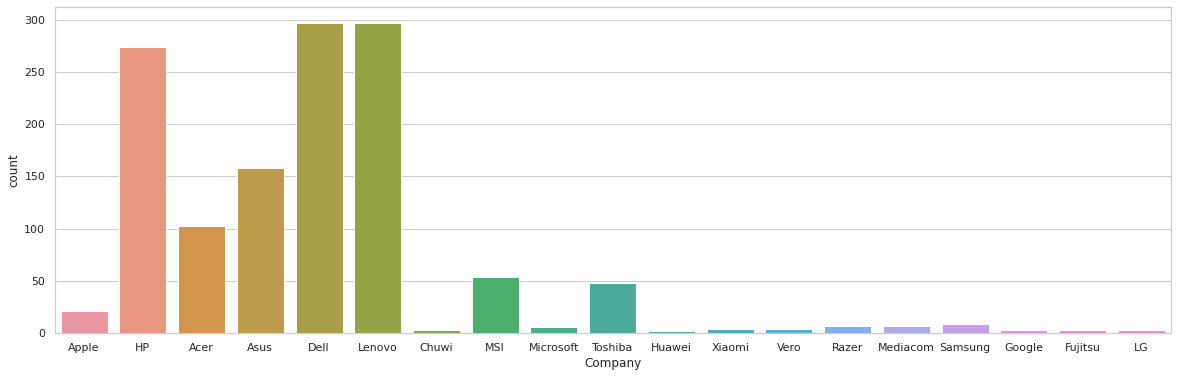

In [ ]:
plt.figure(figsize=(20,6))
sns.countplot(data=df, x='Company')

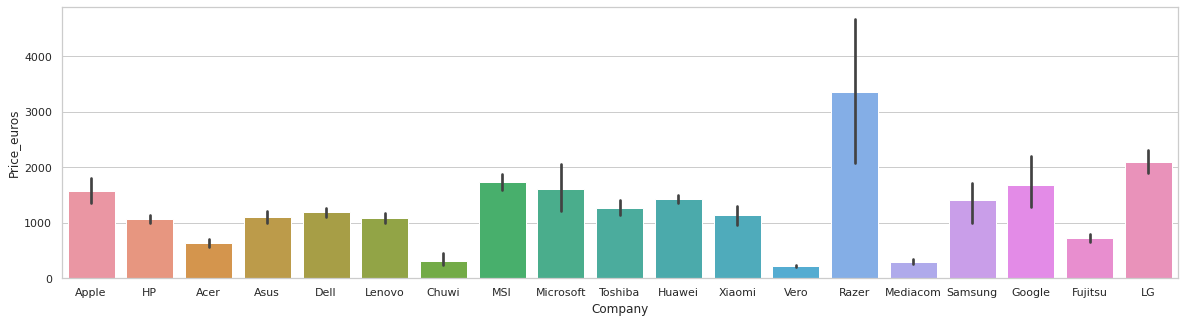

In [ ]:
plt.figure(figsize=(20,5))
sns.barplot(data=df, x='Company', y='Price_euros')

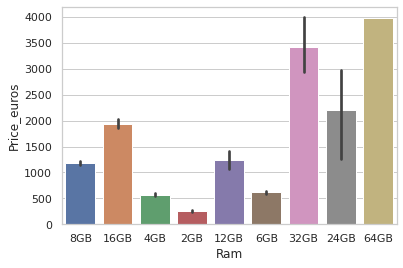

In [ ]:
#plt.figure(figsize=(20,10))
sns.barplot(data=df, x='Ram', y='Price_euros') 

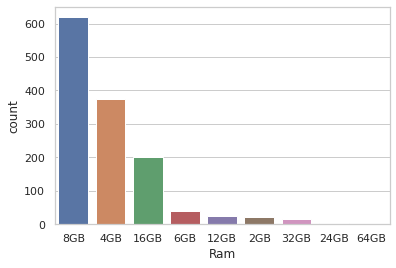

In [ ]:
#plt.figure(figsize=(20,10))
sns.countplot(data=df, x='Ram', order = df['Ram'].value_counts().index)

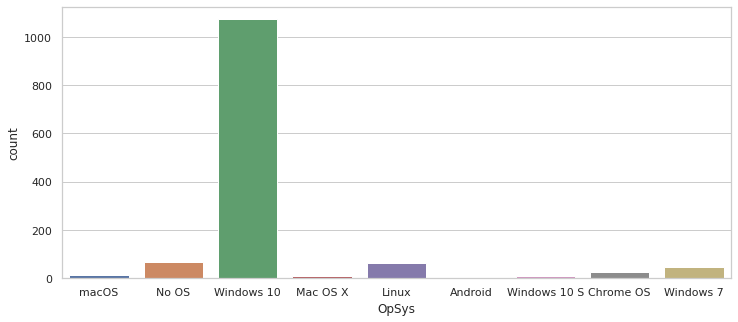

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(data=df, x='OpSys') #, y='Price_euros')

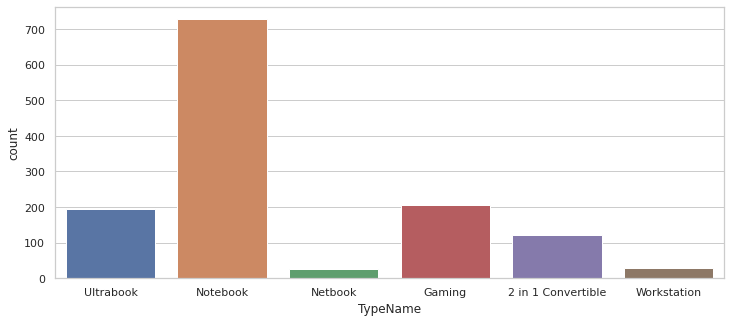

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(data=df, x='TypeName') #, y='Price_euros')

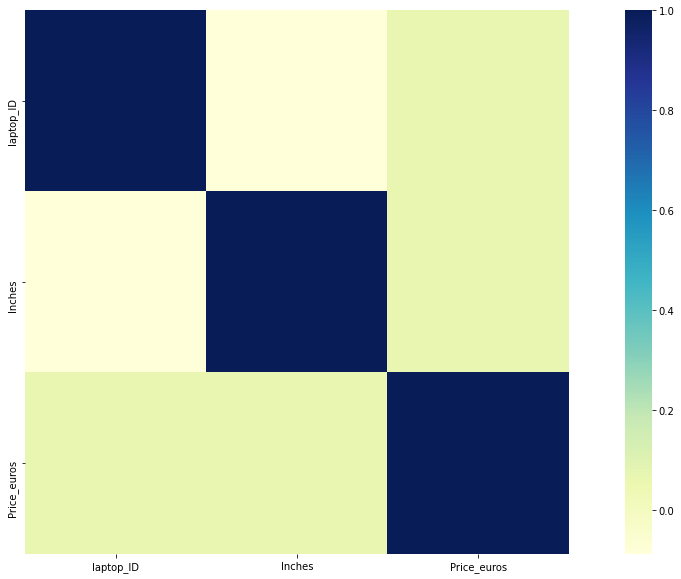

In [ ]:
corr_df = df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr_df , vmax=1, square=True, annot=False, cmap='YlGnBu')

# Data Manipulation

In [ ]:
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [ ]:
pd.get_dummies(df['Company'])

,Acer,Apple,Asus,Chuwi,Dell,Fujitsu,Google,HP,Huawei,LG,Lenovo,MSI,Mediacom,Microsoft,Razer,Samsung,Toshiba,Vero,Xiaomi
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1299,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1300,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1301,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
pd.get_dummies(df.Product)

,110-15ACL (A6-7310/4GB/500GB/W10),14-am079na (N3710/8GB/2TB/W10),15-AC110nv (i7-6500U/6GB/1TB/Radeon,15-AY023na (N3710/8GB/2TB/W10),15-BA015wm (E2-7110/4GB/500GB/W10),15-BS026nv (i5-7200U/8GB/256GB/Radeon,15-BS028nv (i3-6006U/4GB/1TB/Radeon,15-BS078nr (i7-7500U/8GB/1TB/W10),15-BS101nv (i7-8550U/8GB/256GB/FHD/W10),15-BS103nv (i5-8250U/6GB/256GB/Radeon,15-BW004nv (A9-9420/4GB/256GB/Radeon,15-BW037na (A9-9420/4GB/1TB/Radeon,15-BW091ND (A9-9420/6GB/1TB,15-BW094nd (A6-9220/8GB/128GB/W10),15-ay047nv (i3-6006U/6GB/1TB/Radeon,15-ba043na (A12-9700P/8GB/2TB/W10),15-bs002nv (i3-6006U/4GB/128GB/FHD/W10),15-bs005nv (i3-6006U/4GB/1TB,15-bs011nv (i7-7500U/4GB/500GB/Radeon,15-bs012nv (i7-7500U/8GB/1TB/Radeon,15-bs015dx (i5-7200U/8GB/1TB/W10),15-bs017nv (i7-7500U/8GB/256GB/Radeon,15-bs018nq (i3-6006U/4GB/500GB/FHD/No,15-bs023nv (i3-6006U/4GB/1TB/FHD/W10),15-bs024nv (i5-7200U/8GB/128GB/W10),15-bs025nv (i5-7200U/8GB/256GB/W10),15-bs053od (i7-7500U/6GB/1TB/W10),15-bs078cl (i7-7500U/8GB/2TB/W10),15-bs190od (i5-8250U/4GB/1TB/W10),15-bw000nv (E2-9000e/4GB/500GB/Radeon,15-bw002nv (A6-9220/4GB/256GB/Radeon,15-bw003nv (A9-Series-9420/4GB/256GB/FHD/W10),15-bw007nv (A10-9620P/6GB/128GB/Radeon,15-bw009nv (A12-9720P/6GB/1TB/Radeon,15-bw011nv (A6-9220/4GB/1TB/FHD/W10),15-cb003na (i5-7300HQ/8GB/1TB,15-cd005nv (A9-9420/6GB/256GB/Radeon,15-ra044nv (N3060/4GB/500GB/W10),15-rb013nv (E2-9000e/4GB/500GB/W10),17-AK091ND (A9-9420/8GB/1TB/W10),...,Yoga 11e,Yoga 500-14IBD,Yoga 500-14ISK,Yoga 500-15ISK,Yoga 510-15IKB,Yoga 520-14IKB,Yoga 700-11ISK,Yoga 720-13IKB,Yoga 720-15IKB,Yoga 730,Yoga 900-13ISK,Yoga 900S-12ISK,Yoga 910-13IKB,Yoga 920-13IKB,Yoga Book,ZBook 15,ZBook 15u,ZBook 17,ZBook Studio,Zbook 15,Zbook 17,ZenBook 3,ZenBook Flip,ZenBook Pro,ZenBook UX305CA-UBM1,ZenBook UX310UA-FB485T,ZenBook UX310UA-WB71,ZenBook UX310UQ-GL026T,ZenBook UX410UA-GV183T,ZenBook UX430UA,ZenBook UX430UN,ZenBook UX510UX-CN211T,ZenBook UX530UQ-PRO,Zenbook 3,Zenbook Flip,Zenbook UX330UA-AH5Q,Zenbook UX390UA,Zenbook UX410UA-GV027T,Zenbook UX430UA,Zenbook UX510UW-FI095T
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1299,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1301,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
pd.get_dummies(df.TypeName)

,2 in 1 Convertible,Gaming,Netbook,Notebook,Ultrabook,Workstation
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,1,0,0
3,0,0,0,0,1,0
4,0,0,0,0,1,0
...,...,...,...,...,...,...
1298,1,0,0,0,0,0
1299,1,0,0,0,0,0
1300,0,0,0,1,0,0
1301,0,0,0,1,0,0
